# import

In [23]:
import gc
import os
import re
import sys
import time
import warnings

import numpy as np
import pandas as pd
import torch
from matplotlib import pyplot as plt
from sklearn.metrics import (accuracy_score, f1_score, precision_score,
                             recall_score)
from sklearn.model_selection import train_test_split
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from transformers import AutoConfig, AutoModel, AutoTokenizer

In [24]:
#warnings.filterwarnings("ignore")

In [25]:
pd.set_option("display.max_column", 100)
pd.set_option("display.max_row", 100)

# データの読み込み

In [26]:
df = pd.read_csv(
    "/home/jovyan/work/data/train.csv",
    index_col="discourse_id",
    nrows=10000
)

## データのラベル定義

In [27]:
discourse_types = ["Lead", "Position", "Claim", "Evidence", "Counterclaim", "Concluding Statement", "Rebuttal"]
target_col_names = ["Adequate", "Effective", "Ineffective"]

## データ整形

In [28]:
# データの抽出
df = df.loc[
    df["discourse_type"]==discourse_types[0]
]

# データの分割
train, valid_test = train_test_split(
    df, test_size=0.2, shuffle=True, random_state=0, stratify=df["discourse_effectiveness"]
)
valid, test = train_test_split(
    valid_test,
    test_size=0.2,
    shuffle=True,
    random_state=0,
    stratify=valid_test["discourse_effectiveness"],
)

## インデックスの割り当て

In [29]:
def set_index(df, id_col_name):
    df.reset_index(inplace=True)
    index_id = dict(zip(df.index, df[id_col_name]))
    df.drop(id_col_name, inplace=True, axis=1)
    return df, index_id

In [30]:
train, train_index2id = set_index(train, "discourse_id")
valid, valid_index2id = set_index(valid, "discourse_id")
test, test_index2id = set_index(test, "discourse_id")

In [31]:
# 正解ラベルのone-hot化
y_train = pd.get_dummies(train["discourse_effectiveness"]).to_numpy()
y_valid = pd.get_dummies(valid["discourse_effectiveness"]).to_numpy()
y_test = pd.get_dummies(test["discourse_effectiveness"]).to_numpy()

In [32]:
class tokenize(object):
    def __init__(self, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __call__(self, text):
        inputs = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding="max_length",
            truncation=True,
        )
        input_ids = inputs["input_ids"]
        attention_mask = inputs["attention_mask"]
        token_type_ids = inputs["token_type_ids"]

        return {
            "input_ids": torch.LongTensor(input_ids),
            "attention_mask": torch.LongTensor(attention_mask),
            "token_type_ids": torch.LongTensor(token_type_ids),
        }

In [33]:
# Datasetの定義
class CreateDataset(Dataset):
    def __init__(self, X, y, transform):
        self.X = X
        self.y = y
        self.transform=transform
    def __len__(self):  # len(Dataset)で返す値を指定
        return len(self.y)

    def __getitem__(self, index):  # Dataset[index]で返す値を指定
        text = self.X[index]
        output_dict = self.transform(text)
        output_dict["labels"] = torch.Tensor(self.y[index])
        return output_dict

In [34]:
# Datasetの作成
max_len = 128
MODELNAME = "microsoft/deberta-large-mnli"
tokenizer = tokenize(AutoTokenizer.from_pretrained(MODELNAME), max_len)


dataset_train = CreateDataset(train["discourse_text"], y_train, tokenizer)
dataset_valid = CreateDataset(valid["discourse_text"], y_valid, tokenizer)
dataset_test = CreateDataset(test["discourse_text"], y_test, tokenizer)

In [35]:
# BERT分類モデルの抽象クラス
class BERTClass(torch.nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.bert = AutoModel.from_pretrained(
            MODELNAME, output_hidden_states=True
        )

In [36]:
# BERT分類モデルの定義(Linear)
class BERTLinearClass(BERTClass):
    def __init__(self, config):
        super().__init__(config)
        self.drop = nn.Dropout(self.config["drop_rate"])
        self.fc = nn.Linear(
            self.config["hidden_size"], self.config["output_size"]
        )

    def forward(self, input_ids, attention_mask, token_type_ids):
        out = self.bert(
            input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids
        )
        out = self.drop(out.hidden_states[-1])
        out = self.fc(out[:, 0, :])
        return out

In [37]:
# BERT分類モデルの定義(Pooling)
class BERTPoolingClass(BERTClass):
    def __init__(self, config):
        super().__init__(config)
        self.drop = nn.Dropout(self.config["drop_rate"])
        self.drop = nn.Dropout(self.config["drop_rate"])
        self.pooling = nn.AdaptiveMaxPool1d(1)
        self.fc = nn.Linear(
            self.config["hidden_size"], self.config["output_size"]
        )

    def forward(self, input_ids, attention_mask, token_type_ids):
        out = self.bert(
            input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids
        )
        out = self.drop(out.hidden_states[-1])
        out, _ = out.max(1)
        out = self.fc(out)
        return out

In [38]:
# BERT分類モデルの定義(Couvolution)
class BERTConvolutionClass(BERTClass):
    def __init__(self, config):
        super().__init__(config)
        self.drop = nn.Dropout(self.config["drop_rate"])
        self.cnn1 = nn.Conv1d(
            self.config["hidden_size"], 256, kernel_size=2, padding=1
        )
        self.cnn2 = nn.Conv1d(256, 1, kernel_size=2, padding=1)

    def forward(self, input_ids, attention_mask, token_type_ids):
        out = (
            self.bert(
                input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids
            )
            .hidden_states[-1]
            .permute(0, 2, 1)
        )
        out = nn.functional.relu(self.cnn1(out))
        out = self.cnn2(out)
        out, _ = torch.max(out, 2)
        return out

In [39]:
# BERT分類モデルの定義(Concatenate)
class BERTConcatenateClass(BERTClass):
    def __init__(self, config):
        super().__init__(config)
        self.drop = nn.Dropout(self.config["drop_rate"])
        self.fc = nn.Linear(
            self.config["hidden_size"] * 4, self.config["output_size"]
        )

    def forward(self, input_ids, attention_mask, token_type_ids):
        out = self.bert(
            input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids
        )
        out = torch.cat(
            [out["hidden_states"][-1 * i][:, 0] for i in range(1, 4 + 1)], dim=1
        )  # concatenate
        out = self.fc(out)

        return out

In [40]:
# パラメータの設定
config = AutoConfig.from_pretrained(MODELNAME).to_dict()
config["drop_rate"] = 0.4
config["output_size"] = 3
config["train_batch_size"] = 4
config["valid_batch_size"] = 4
config["num_epochs"] = 4
config["learning_rate"] = 5e-4

In [41]:
# デバイスの指定
device = torch.device("cuda:0")
# モデルの定義
model = BERTLinearClass(config)
model.load_state_dict(torch.load("checkpoint_model.pth"))
model.to(device)

Some weights of the model checkpoint at microsoft/deberta-large-mnli were not used when initializing DebertaModel: ['config', 'classifier.bias', 'pooler.dense.bias', 'classifier.weight', 'pooler.dense.weight']
- This IS expected if you are initializing DebertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BERTLinearClass(
  (bert): DebertaModel(
    (embeddings): DebertaEmbeddings(
      (word_embeddings): Embedding(50265, 1024, padding_idx=0)
      (LayerNorm): DebertaLayerNorm()
      (dropout): StableDropout()
    )
    (encoder): DebertaEncoder(
      (layer): ModuleList(
        (0): DebertaLayer(
          (attention): DebertaAttention(
            (self): DisentangledSelfAttention(
              (in_proj): Linear(in_features=1024, out_features=3072, bias=False)
              (pos_dropout): StableDropout()
              (pos_proj): Linear(in_features=1024, out_features=1024, bias=False)
              (pos_q_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): StableDropout()
            )
            (output): DebertaSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): DebertaLayerNorm()
              (dropout): StableDropout()
            )
          )
          (intermediate): Deber

In [42]:
def prediction(model, dataset, device):
    # Dataloaderの作成
    loader = DataLoader(dataset, batch_size=100, shuffle=False)

    model.eval()
  
    prob = []
    pred = []
    label = []
    with torch.no_grad():
        for data in loader:
            # デバイスの指定
            input_ids = data["input_ids"].to(device)
            attention_mask = data["attention_mask"].to(device)
            token_type_ids = data["token_type_ids"].to(device)
            label.append(data["labels"].to(device))

            # 順伝播 + 予測値の取得 
            outputs = model.forward(input_ids, attention_mask, token_type_ids)
            prob.append(torch.sigmoid(outputs))
            pred.append(torch.where(outputs>0.5, 1, 0))
            
        pred = torch.cat(pred, dim=0)
        prob = torch.cat(prob, dim=0)
        label = torch.cat(label, dim=0)
        
        del model, loader
        gc.collect()
        return pred, label, prob

In [43]:
pred_train, label_train, prob_train = prediction(model, dataset_train, device)
pred_valid, label_valid, prob_valid = prediction(model, dataset_valid, device)
pred_test, label_test, prob_test = prediction(model, dataset_test, device)

In [44]:
dataTypes = ["pred", "label", "prob"]
trains = [pred_train, label_train, prob_train]
valids = [pred_valid, label_valid, prob_valid]
tests = [pred_test, label_test, prob_test ]

In [45]:
trains = dict(
    zip(
        dataTypes,
        [pd.DataFrame(_.cpu().numpy(), columns=target_col_names) for _ in trains],
    )
)
valids = dict(
    zip(
        dataTypes,
        [pd.DataFrame(_.cpu().numpy(), columns=target_col_names) for _ in valids],
    )
)
tests = dict(
    zip(
        dataTypes,
        [pd.DataFrame(_.cpu().numpy(), columns=target_col_names) for _ in tests],
    )
)

In [46]:
#precision, recallの算出
def calculate_pr_rc(pred, label):
    pr_rc = []
    for col in pred.columns:
        pr = precision_score(pred.loc[:, col].values, label.loc[:, col].values)
        rc = recall_score(pred.loc[:, col].values, label.loc[:, col].values)
        pr_rc.append([pr, rc])
    return pr_rc

In [47]:
test_pr_rc = pd.DataFrame(
    calculate_pr_rc(tests["pred"], tests["label"]),
    index=target_col_names,
    columns=["precision", "recall"]
).T

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [48]:
def plot_performance(performances):
    plt.rcParams["font.size"] = 16
    
    length = len(performances.columns)
    
    plt.figure(figsize=(25, 10))
    left = np.arange(length)
    
    plt.bar(left - 0.2, performances.loc["precision", :], width=0.4, label="precision")
    plt.bar(left + 0.2, performances.loc["recall", :], width=0.4, label="recall")
    plt.xticks(np.arange(length), performances.columns.tolist(), rotation=90)
    plt.yticks(np.arange(11)*0.1, np.round(np.arange(11)*0.1, 1))
    plt.grid(axis="y")
    plt.title("precision  vs recall ")
    plt.legend(loc="upper left")
    plt.show()

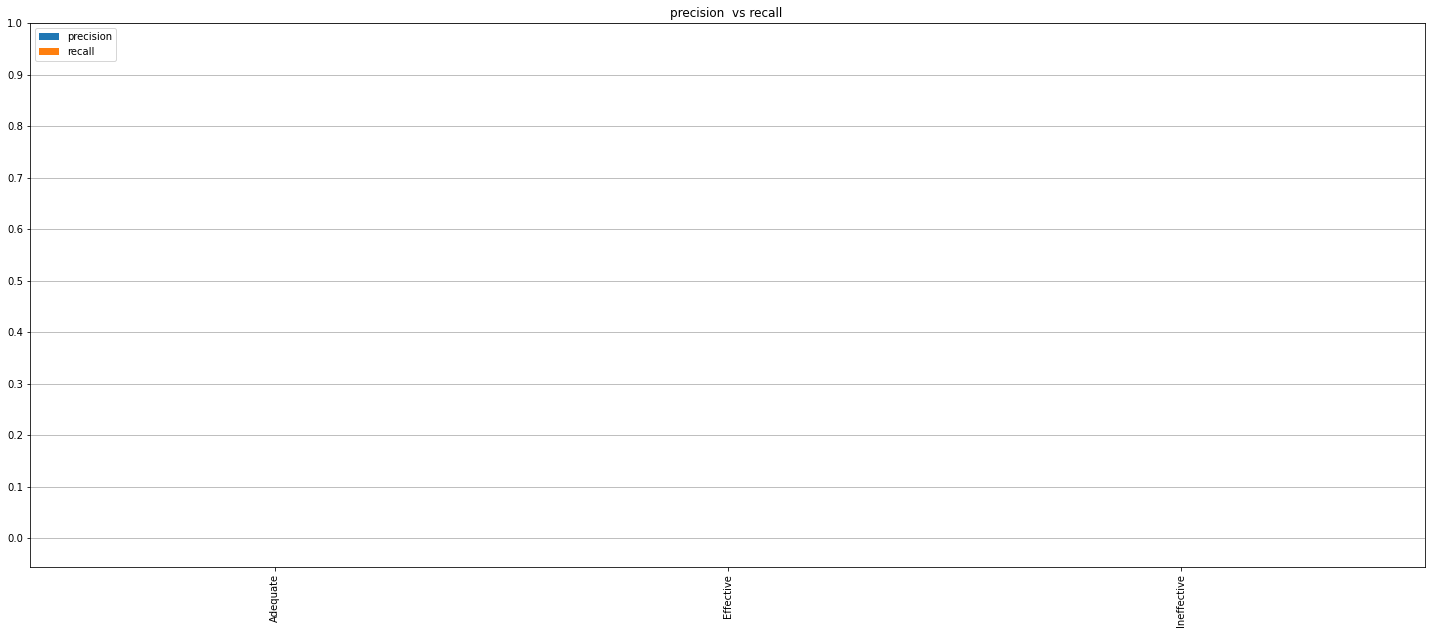

In [49]:
plot_performance(test_pr_rc)